# Exploration of geographically weighted random forest classification modelling

To-do:
- [x] global model
- [x] model evaluation
- [x] bandwidth optimisation
- [x] feature importances
- [x] golden section bandwidth selection
- [x] other metrics than accuracy
- [x] generic support (logistic regression, gradient boosting)
- [x] dedicated classes
- [ ] local performance of models that do not support OOB
    - [x] with logistic regression I guess we can do predict_proba and measure those on the full sample directly
    - with gradient boosting we can't as the model has seen the data - might need to split to train/test to mimic OOB.
- [x] logistic regression local coefficients
- [x] (optionally) predict method

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from geodatasets import get_path
from sklearn import metrics, preprocessing

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression
from gwlearn.search import BandwidthSearch


Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr"))

In [3]:
gdf.shape

(3085, 70)

In [4]:
# It is in the geographic coords in the  US and we need to work with distances. Re-project and use only points as the graph builder will require points anyway.
gdf = gdf.set_geometry(gdf.representative_point()).to_crs(5070)

In [5]:
y = gdf["FH90"] > gdf["FH90"].median()

### Random forest

In [6]:
gwrf = GWRandomForestClassifier(
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwrf.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

GWRandomForestClassifier(bandwidth=250, oob_score=True)

Global OOB accuracy for the GW model measured based on OOB predictions from individual local trees.

In [7]:
gwrf.oob_score_

0.7641160173160173

In [8]:
gwrf.oob_precision_

0.7677441186728038

In [9]:
gwrf.oob_recall_

0.7632663009522763

In [10]:
gwrf.oob_balanced_accuracy_

np.float64(0.7641235941549899)

Local OOB accuracy.

<Axes: >

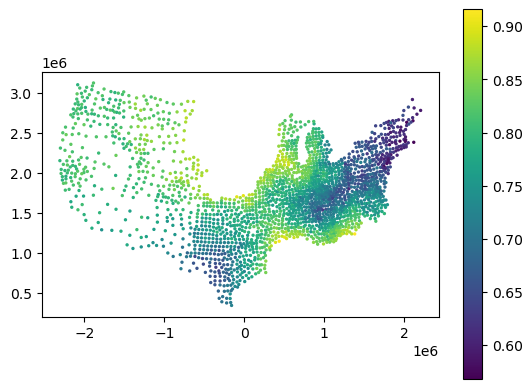

In [11]:
gdf.plot(gwrf.local_oob_score_, legend=True, s=2)

<Axes: >

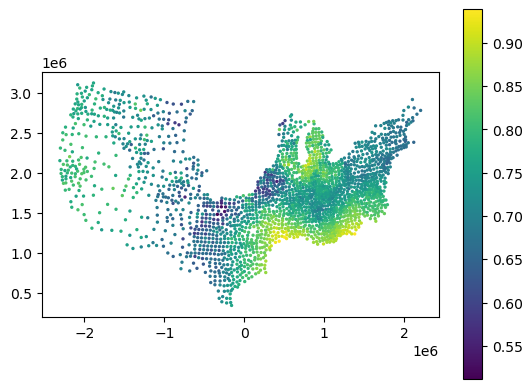

In [12]:
gdf.plot(gwrf.local_oob_precision_, legend=True, s=2)

<Axes: >

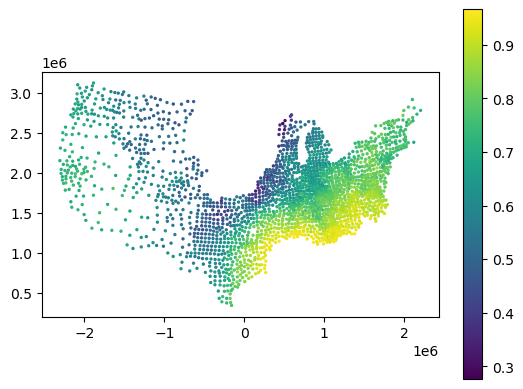

In [13]:
gdf.plot(gwrf.local_oob_recall_, legend=True, s=2)

<Axes: >

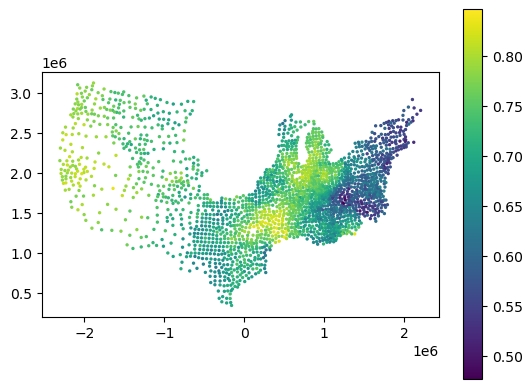

In [14]:
gdf.plot(gwrf.local_oob_balanced_accuracy_, legend=True, s=2)

<Axes: >

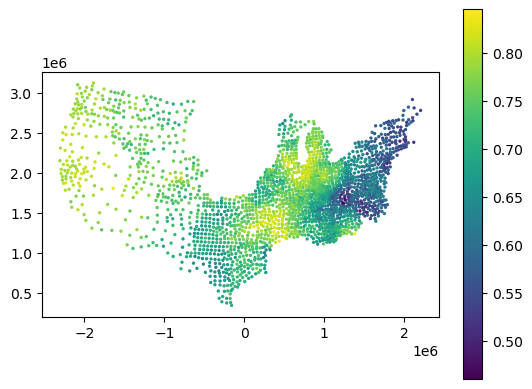

In [15]:
gdf.plot(gwrf.local_oob_f1_macro_, legend=True, s=2)

<Axes: >

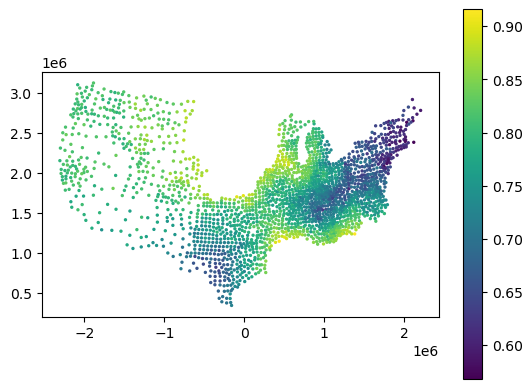

In [16]:
gdf.plot(gwrf.local_oob_f1_micro_, legend=True, s=2)

<Axes: >

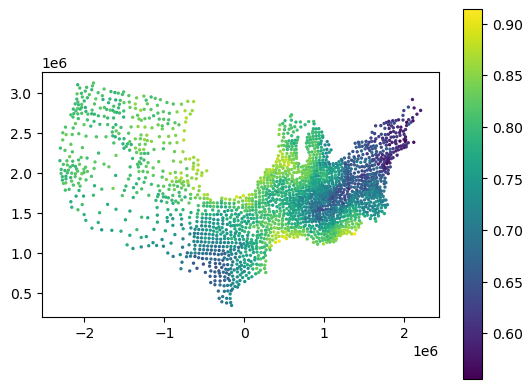

In [17]:
gdf.plot(gwrf.local_oob_f1_weighted_, legend=True, s=2)

<Axes: >

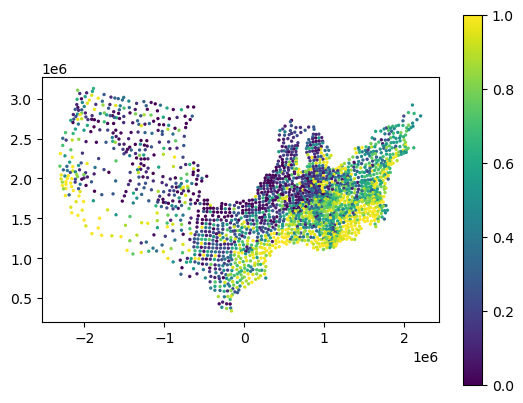

In [18]:
gdf.plot(gwrf.proba_[True], legend=True, s=2)

<Axes: >

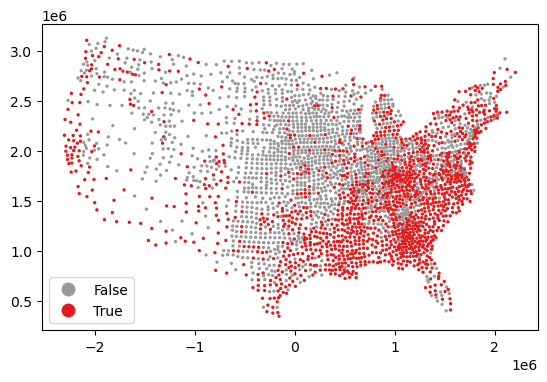

In [19]:
gdf.plot(y, legend=True, s=2, cmap="Set1_r")

Global accuracy for the GW model measured based on prediction of focals.

In [20]:
gwrf.score_

0.7675324675324675

F1 scores for the GW model measured based on prediction of focals. 

In [21]:
gwrf.f1_macro_, gwrf.f1_micro_, gwrf.f1_weighted_

(0.7673248690432178, 0.7675324675324675, 0.767589632333855)

OOB score (accuracy) of the global model.

In [22]:
gwrf.global_model.oob_score_

0.7841166936790924

Get local feature importances.

In [23]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.154289,0.152820,0.122517,0.170999,0.176221,0.223155
2,0.153024,0.147969,0.140062,0.155552,0.200999,0.202394
3,0.140392,0.146422,0.119410,0.158622,0.191062,0.244091
4,0.149664,0.143746,0.124123,0.180672,0.179774,0.222022
...,...,...,...,...,...,...
3080,0.149426,0.115482,0.200406,0.095226,0.259447,0.180013
3081,0.152374,0.109819,0.148292,0.203573,0.220190,0.165754
3082,0.153486,0.185843,0.193443,0.222949,0.107012,0.137266
3083,0.163630,0.169511,0.175803,0.260219,0.109516,0.121322


<Axes: >

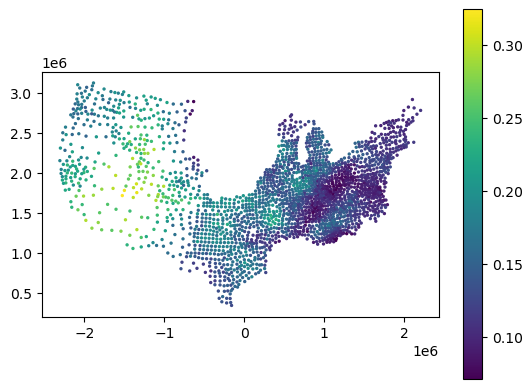

In [24]:
gdf.plot(gwrf.feature_importances_["HC60"], legend=True, s=2)

Compare to global feature importance.

In [25]:
gwrf.global_model.feature_importances_

array([0.13750072, 0.15168332, 0.19208215, 0.18647619, 0.15890345,
       0.17335417])

### Gradient boosting

In [26]:
gwgb = GWGradientBoostingClassifier(
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwgb.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

GWGradientBoostingClassifier(bandwidth=250)

Global score (accuracy) for the GW model measured based on prediction of focals.

In [27]:
gwgb.score_

0.7541125541125541

F1 scores for the GW model measured based on prediction of focals. 

In [28]:
gwgb.f1_macro_, gwgb.f1_micro_, gwgb.f1_weighted_

(0.7539236654736193, 0.7541125541125541, 0.7541833873521547)

Get local feature importances.

In [29]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.179025,0.127350,0.061596,0.156854,0.153030,0.322145
2,0.183341,0.127038,0.062094,0.168145,0.120603,0.338779
3,0.149419,0.138369,0.074860,0.171655,0.069215,0.396482
4,0.177696,0.127365,0.076218,0.151980,0.113298,0.353443
...,...,...,...,...,...,...
3080,0.108015,0.055842,0.145018,0.049287,0.579755,0.062083
3081,0.089986,0.068142,0.140738,0.213208,0.452689,0.035237
3082,0.109944,0.195595,0.192419,0.309176,0.066697,0.126169
3083,0.149320,0.145394,0.155494,0.383279,0.045921,0.120592


<Axes: >

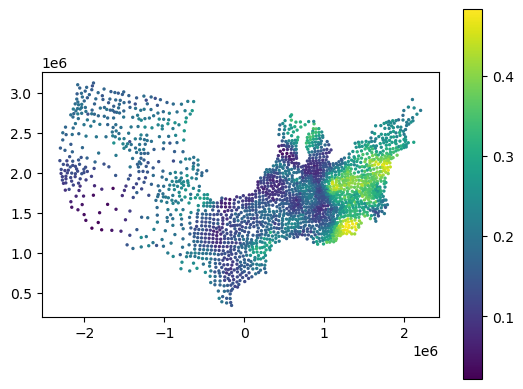

In [30]:
gdf.plot(gwgb.feature_importances_["HR90"], legend=True, s=2)

Compare to global feature importance.

In [31]:
gwgb.global_model.feature_importances_

array([0.05162468, 0.0560755 , 0.12292693, 0.15111514, 0.22509704,
       0.39316073])

### Logistic regression

In [32]:
gwlr = GWLogisticRegression(
    bandwidth=900_000,
    fixed=True,
    n_jobs=-1,
    keep_models=True,
    max_iter=500,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
    gdf.geometry,
)

GWLogisticRegression(
    bandwidth=900000,
    fixed=True,
    keep_models=True,
    max_iter=500
)

In [33]:
gwlr.score_

0.7991746905089409

In [34]:
gwlr.pred_f1_micro_

AttributeError: 'GWLogisticRegression' object has no attribute 'pred_f1_micro_'

<Axes: >

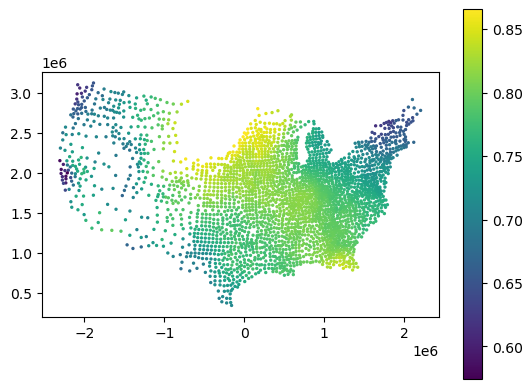

In [ ]:
gdf.plot(gwlr.local_pred_f1_micro_, legend=True, s=2)

In [ ]:
gwlr.f1_macro_, gwlr.f1_micro_, gwlr.f1_weighted_

(0.7911541287072663, 0.7911936704506364, 0.7912401319990963)

Local coefficients

In [ ]:
gwlr.local_coef_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.286802,0.123161,0.099993,0.359248,1.357041,0.864515
2,0.311253,0.157535,0.046688,0.273231,1.380707,0.857892
3,0.299757,0.198515,0.035917,0.216032,1.324819,0.895019
4,0.309365,0.149005,0.073854,0.276963,1.378795,0.840442
...,...,...,...,...,...,...
3080,0.084373,0.360897,0.506413,-0.027660,1.115072,0.724758
3081,0.118441,0.106981,0.573711,0.347592,1.512293,0.827530
3082,-0.115461,0.503123,0.322601,0.657267,1.764582,1.215657
3083,-0.142727,0.468729,0.371395,0.609215,2.124454,1.390968


<Axes: >

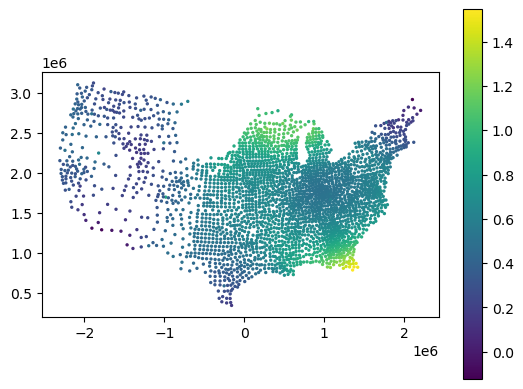

In [ ]:
gdf.plot(gwlr.local_coef_["HR90"], legend=True, s=2)

Local intercepts

<Axes: >

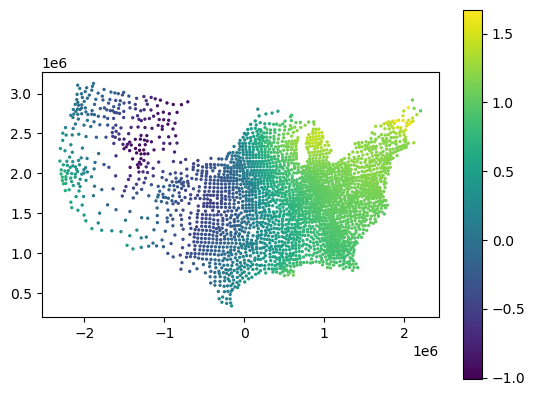

In [ ]:
gdf.plot(gwlr.local_intercept_, s=2, legend=True)

## Bandwidth search

Golden section search with a fixed distance bandwidth.

In [ ]:
search = BandwidthSearch(
    GWLogisticRegression,
    fixed=True,
    n_jobs=-1,
    search_method="golden_section",
    criterion="aic",
    max_iterations=3,
    min_bandwidth=250_000,
    max_bandwidth=2_000_000,
    verbose=True,
    max_iter=500,
)
search.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Fitting bandwidth: 918447.5
-0.4081785661481215 2918 6
Bandwidth: 918447.5, Score: 12.816
Fitting bandwidth: 1331552.5
-0.4112848331214553 3073 6
Bandwidth: 1331552.5, score: 12.823


Get the optimal one.

In [ ]:
search.scores_

918447.5     12.816357
1331552.5    12.822570
Name: oob_score, dtype: float64

Golden section search with an adaptive KNN bandwidth.

In [ ]:
search = BandwidthSearch(
    GWLogisticRegression,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=50,
    max_bandwidth=1000,
    interval=100,
    criterion="aicc",
    verbose=True,
    max_iter=500,  # passed to log regr
)
search.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    y,
    gdf.geometry,
)

Bandwidth: 50.00, score: 3496.602
Bandwidth: 150.00, score: 2590.608
Bandwidth: 250.00, score: 2470.417
Bandwidth: 350.00, score: 2467.736
Bandwidth: 450.00, score: 2507.082
Bandwidth: 550.00, score: 2522.316
Bandwidth: 650.00, score: 2543.729
Bandwidth: 750.00, score: 2612.469
Bandwidth: 850.00, score: 2655.850
Bandwidth: 950.00, score: 2712.442


<Axes: >

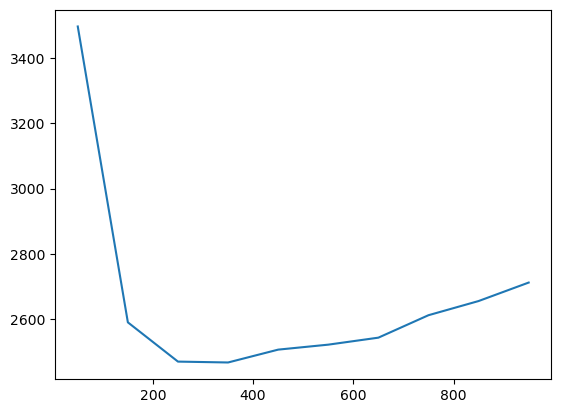

In [ ]:
search.scores_.plot()

Get the optimal one.

In [ ]:
search.optimal_bandwidth_

np.int64(350)

## Prediction

If you want to use the model for prediction, all the local models need to be retained. That may require significant memory for RF.

In [ ]:
gwlr = GWLogisticRegression(
    bandwidth=918447,
    fixed=True,
    n_jobs=-1,
    verbose=True,
    max_iter=500,  # passed to log regr
    measure_performance=False,
    keep_models=True,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
    gdf.geometry,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
all_data = pd.DataFrame(
    preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
)

Predict probabilities

In [ ]:
pp = gwlr.predict_proba(all_data.iloc[:10], geometry=gdf.geometry.iloc[:10])
pp

,False,True
0,0.820086,0.179914
1,0.620665,0.379335
2,0.692175,0.307825
3,0.650646,0.349354
4,0.717526,0.282474
5,0.757832,0.242168
6,0.643172,0.356828
7,0.772874,0.227126
8,0.534443,0.465557
9,0.785177,0.214823


Predict label (taking max of probabilities)

In [ ]:
gwlr.predict(all_data.iloc[5:10], geometry=gdf.geometry.iloc[5:10])

5    False
6    False
7    False
8    False
9    False
dtype: bool